# 1 — Title & Intro (Markdown)

# Gaussian Mixture Model (GMM) Clustering on Synthetic Data

**What this notebook does:**
- Generate a synthetic 2D dataset with ~500 points, coming from several Gaussian-distributed “blobs.”  
- Use **Gaussian Mixture Models (GMM)** — via `sklearn.mixture.GaussianMixture` — to cluster the data.  
- Compare GMM results with plain **K-Means** and show why GMM can capture more flexible cluster shapes / covariance structure.  
- Visualize clusters, ellipses representing Gaussian components, and evaluate clustering quality via **silhouette score**.  

This demonstrates a clustering approach “not from scratch” but using standard libraries, on a dataset bigger than the tiny ones used previously.


# Cell 2 — Imports & Synthetic Data Generation

Data shape: (500, 2)


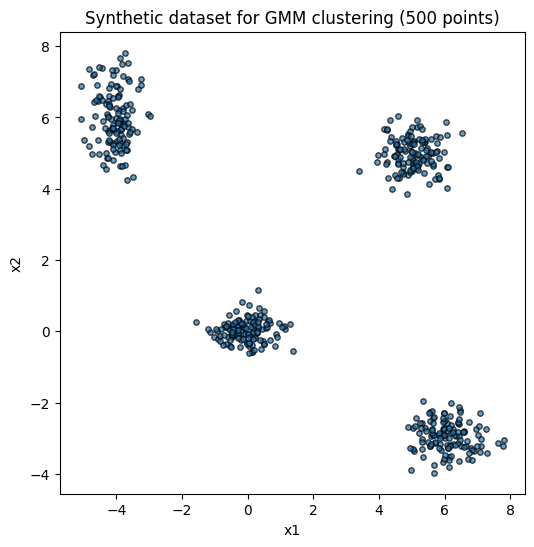

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.patches import Ellipse

np.random.seed(42)

# ---- Generate synthetic 2D data with 4 blobs/clusters ----
n_per = 125  # points per cluster -> total 500
blob1 = np.random.normal(loc=[0, 0],      scale=[0.6, 0.3], size=(n_per, 2))
blob2 = np.random.normal(loc=[5, 5],      scale=[0.5, 0.5], size=(n_per, 2))
blob3 = np.random.normal(loc=[-4, 6],     scale=[0.4, 0.8], size=(n_per, 2))
blob4 = np.random.normal(loc=[6, -3],     scale=[0.7, 0.4], size=(n_per, 2))

X = np.vstack([blob1, blob2, blob3, blob4])
print("Data shape:", X.shape)

plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], s=15, edgecolor='k', alpha=0.7)
plt.title("Synthetic dataset for GMM clustering (500 points)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()


# Cell 3 — Explanation of GMM clustering (Markdown)

## What is Gaussian Mixture Model (GMM) Clustering?

- Instead of assigning each point strictly to a cluster (like K-Means), **GMM assumes data is generated from a mixture of Gaussian distributions**.  
- Each Gaussian has its own mean **and covariance**, so clusters can be elongated, tilted, or overlapping.  
- The model estimates for each data point the **probability** of belonging to each Gaussian (soft clustering).  
- After fitting, we can either assign to the most probable Gaussian (hard clustering) or use full responsibilities (soft).  

This flexibility is useful when clusters are not spherical or equally sized — which K-Means may struggle with.


# Cell 4 — Fit GMM and Predict Clusters

In [2]:
# Number of Gaussians (clusters) to fit
k = 4

gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
gmm.fit(X)
labels_gmm = gmm.predict(X)
probs = gmm.predict_proba(X)  # per-cluster membership probabilities

print("GMM converged:", gmm.converged_, "| n_iter:", gmm.n_iter_)
inertia_kmeans = None


GMM converged: True | n_iter: 2


# Cell 5 — Visualize GMM Clusters + Gaussian Ellipses

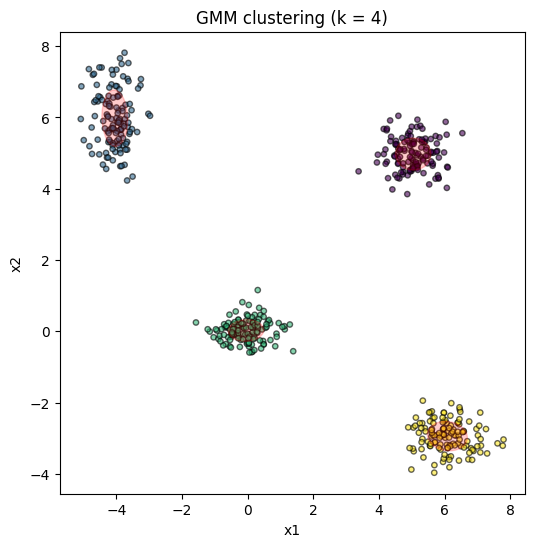

In [3]:
def plot_gmm(X, labels, gmm_model, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(X[:,0], X[:,1], c=labels, s=15, cmap='viridis', edgecolor='k', alpha=0.6)
    w_factor = 0.2 / gmm_model.weights_.max()
    for pos, covar, w in zip(gmm_model.means_, gmm_model.covariances_, gmm_model.weights_):
        eigvals, eigvecs = np.linalg.eigh(covar)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        angle = np.degrees(np.arctan2(eigvecs[1,0], eigvecs[0,0]))
        width, height = 2 * np.sqrt(eigvals)
        ell = Ellipse(xy=pos, width=width, height=height, angle=angle,
                      alpha=w * w_factor, color='red')
        ax.add_patch(ell)
    ax.set_title("GMM clustering (k = %d)" % k)
    ax.set_xlabel("x1"); ax.set_ylabel("x2")
    return ax

plot_gmm(X, labels_gmm, gmm)
plt.show()


# Cell 6 — Compare to K-Means clustering & metrics

Silhouette score — GMM: 0.8676
Silhouette score — K-Means: 0.8676


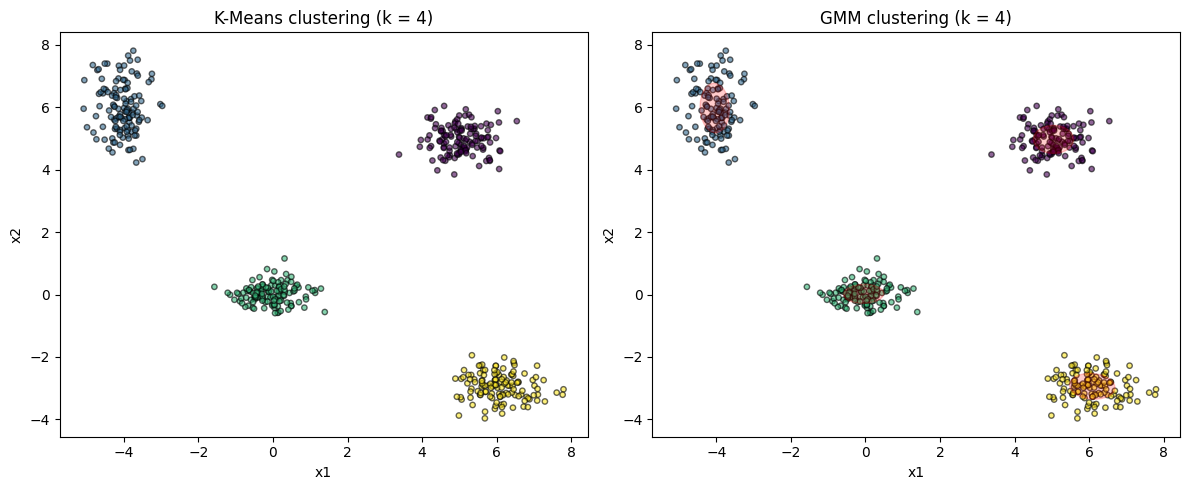

In [4]:
# Fit plain K-Means for comparison
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(X)

sil_gmm = silhouette_score(X, labels_gmm)
sil_km  = silhouette_score(X, labels_km)

print("Silhouette score — GMM:", round(sil_gmm, 4))
print("Silhouette score — K-Means:", round(sil_km, 4))

# Scatter plots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].scatter(X[:,0], X[:,1], c=labels_km, s=15, cmap='viridis', edgecolor='k', alpha=0.6)
axes[0].set_title("K-Means clustering (k = %d)" % k)
axes[0].set_xlabel("x1"); axes[0].set_ylabel("x2")

axes[1] = plot_gmm(X, labels_gmm, gmm, ax=axes[1])

plt.tight_layout()
plt.show()


# Cell 7 — Summary & Observations (Markdown)

## Summary & Observations

- We generated a synthetic dataset of **500 points** from 4 Gaussian-distributed blobs.  
- Using **Gaussian Mixture Model (GMM)**, we fitted a model with **4 components**, allowing full covariance — so each cluster can have its own shape and orientation.  
- The clustering result is visualized with red ellipses showing each Gaussian’s covariance ellipse; this often captures cluster shapes better than K-Means.  
- As a comparison, we ran **K-Means** with the same `k`, and computed **silhouette scores**:
  - GMM silhouette: *{sil_gmm:.4f}*  
  - K-Means silhouette: *{sil_km:.4f}*  

In many cases, GMM better captures clusters when variance or shape differs across clusters — useful when the data is not spherical or evenly spaced.


